
# Export/Import assets with `ibm-watson-machine-learning`

This notebook demonstrates an example for exporting/importing assets using Watson Machine Learning service. It contains steps and code to work with [ibm-watson-machine-learning](https://pypi.python.org/pypi/ibm-watson-machine-learning) library available in PyPI repository.

## Learning goals

The learning goals of this notebook are:

-  Download an externally trained Keras model.
-  Persist an external model in Watson Machine Learning repository.
-  Export the model from the space
-  Import the model to another space and deploy



## Contents

This notebook contains the following parts:

1.	[Setup](#setup)
2.	[Download externally created Keras model](#download)
3.	[Persist externally created Keras model](#persistence)
4.	[Export the model](#export)
5.	[Import the model](#import)
6.	[Deploy and score the imported model](#scoring)
7.  [Clean up](#cleanup)
8.	[Summary and next steps](#summary)

<a id="setup"></a>
## 1. Set up the environment

Before you use the sample code in this notebook, you must perform the following setup tasks:

-  Create a <a href="https://console.ng.bluemix.net/catalog/services/ibm-watson-machine-learning/" target="_blank" rel="noopener no referrer">Watson Machine Learning (WML) Service</a> instance (a free plan is offered and information about how to create the instance can be found <a href="https://dataplatform.ibm.com/docs/content/analyze-data/wml-setup.html" target="_blank" rel="noopener no referrer">here</a>).

### Connection to WML

Authenticate the Watson Machine Learning service on IBM Cloud. You need to provide platform `api_key` and instance `location`.

You can use [IBM Cloud CLI](https://cloud.ibm.com/docs/cli/index.html) to retrieve platform API Key and instance location.

API Key can be generated in the following way:
```
ibmcloud login
ibmcloud iam api-key-create API_KEY_NAME
```

In result, get the value of `api_key` from the output.


Location of your WML instance can be retrieved in the following way:
```
ibmcloud login --apikey API_KEY -a https://cloud.ibm.com
ibmcloud resource service-instance WML_INSTANCE_NAME
```

In result, get the value of `location` from the output.

**Tip**: Your `Cloud API key` can be generated by going to the [**Users** section of the Cloud console](https://cloud.ibm.com/iam#/users). From that page, click your name, scroll down to the **API Keys** section, and click **Create an IBM Cloud API key**. Give your key a name and click **Create**, then copy the created key and paste it below. You can also get a service specific url by going to the [**Endpoint URLs** section of the Watson Machine Learning docs](https://cloud.ibm.com/apidocs/machine-learning).  You can check your instance location in your  <a href="https://console.ng.bluemix.net/catalog/services/ibm-watson-machine-learning/" target="_blank" rel="noopener no referrer">Watson Machine Learning (WML) Service</a> instance details.

You can also get service specific apikey by going to the [**Service IDs** section of the Cloud Console](https://cloud.ibm.com/iam/serviceids).  From that page, click **Create**, then copy the created key and paste it below.

**Action**: Enter your `api_key` and `location` in the following cell.

In [35]:
api_key = 'PASTE YOUR PLATFORM API KEY HERE'
location = 'PASTE YOUR INSTANCE LOCATION HERE'

In [36]:
wml_credentials = {
    "apikey": api_key,
    "url": 'https://' + location + '.ml.cloud.ibm.com'
}

### Install and import the latest `ibm-watson-machine-learning` package
**Note:** `ibm-watson-machine-learning` documentation can be found <a href="http://ibm-wml-api-pyclient.mybluemix.net/" target="_blank" rel="noopener no referrer">here</a>. Latest client can be found <a href="https://pypi.org/project/ibm-watson-machine-learning/" rel="noopener no referrer">here.</a>

In [37]:
from ibm_watson_machine_learning import APIClient

client = APIClient(wml_credentials)

DEPRECATED!!! Python 3.6 framework is deprecated and will be removed on Jan 20, 2021. Use Python 3.7 instead. For details, see https://dataplatform.cloud.ibm.com/docs/content/wsj/analyze-data/pm_service_supported_frameworks.html


### Create two spaces. One for export and one for import

**Tip**: You can refer to details and example for space management apis [here](https://github.com/IBM/watson-machine-learning-samples/blob/master/cloud/notebooks/python_sdk/instance-management/Space%20management.ipynb)


In [ ]:
# Refer to the link in above Tip how to find the cos and instance crns
cos_resource_crn = "PUT_YOUR_COS_CRN"
instance_crn = "PUT_YOUR_WML_INSTANCE_CRN"
name = "PUT_YOUR_WML_INSTANCE_NAME_HERE"

In [39]:
import uuid

space_name = str(uuid.uuid4())


export_space_metadata = {
              client.spaces.ConfigurationMetaNames.NAME: "client_space_export_" + space_name,
              client.spaces.ConfigurationMetaNames.DESCRIPTION: space_name + " description",
              client.spaces.ConfigurationMetaNames.STORAGE: { "resource_crn": cos_resource_crn},
              client.spaces.ConfigurationMetaNames.COMPUTE: {
                         "name": name,
                         "crn": instance_crn
              }
}

space = client.spaces.store(meta_props=export_space_metadata)

export_space_id = client.spaces.get_id(space)
print("{}export space_id: {}{}".format('\n', export_space_id, '\n'))


import_space_metadata = {
              client.spaces.ConfigurationMetaNames.NAME: "client_space_import_" + space_name,
              client.spaces.ConfigurationMetaNames.DESCRIPTION: space_name +  "description",
              client.spaces.ConfigurationMetaNames.STORAGE: {"resource_crn": cos_resource_crn},
              client.spaces.ConfigurationMetaNames.COMPUTE: {
                         "name": name,
                         "crn": instance_crn
              }
}

space = client.spaces.store(meta_props=import_space_metadata)

import_space_id = client.spaces.get_id(space)
print("{}import space_id: {}".format('\n', import_space_id))

Space has been created. However some background setup activities might still be on-going. Check for 'status' field in the response. It has to show 'active' before space can be used. If its not 'active', you can monitor the state with a call to spaces.get_details(space_id)

export space_id: 4214bd0c-d6d9-4e1d-80b1-2dd0b23b50df

Space has been created. However some background setup activities might still be on-going. Check for 'status' field in the response. It has to show 'active' before space can be used. If its not 'active', you can monitor the state with a call to spaces.get_details(space_id)

import space_id: 65fe28f3-9fff-4582-b456-5d4af6a7d796


<a id="download"></a>
## 2. Download externally created Keras model and data
In this section, you will download externally created Keras models and data used for training it.

In [40]:
import os
import wget
import ssl

data_dir = 'MNIST_DATA'
if not os.path.isdir(data_dir):
    os.mkdir(data_dir)
    
model_path = os.path.join(data_dir, 'mnist_keras.h5.tgz')
if not os.path.isfile(model_path):
    wget.download("https://github.com/IBM/watson-machine-learning-samples/raw/master/cloud/models/keras/mnist_keras.h5.tgz", out=data_dir)

In [41]:
import os
import wget

data_dir = 'MNIST_DATA'
if not os.path.isdir(data_dir):
    os.mkdir(data_dir)
    
filename = os.path.join(data_dir, 'mnist.npz')
if not os.path.isfile(filename):
    wget.download('https://s3.amazonaws.com/img-datasets/mnist.npz', out=data_dir)  

In [42]:
import numpy as np

dataset = np.load(filename)
x_test = dataset['x_test']

<a id="persistence"></a>
## 3. Persist externally created Keras model

In this section, you will learn how to store your model in Watson Machine Learning repository by using the Watson Machine Learning Client.

### 3.1: Publish model

Define model name, type and software specification needed to deploy model later.

In [43]:
sofware_spec_uid = client.software_specifications.get_id_by_name("default_py3.7")

In [44]:
client.set.default_space(export_space_id)

metadata = {
            client.repository.ModelMetaNames.NAME: 'External Keras model',
            client.repository.ModelMetaNames.TYPE: 'tensorflow_2.1',
            client.repository.ModelMetaNames.SOFTWARE_SPEC_UID: sofware_spec_uid
}

published_model = client.repository.store_model(
    model=model_path,
    meta_props=metadata)

### 3.2: Get model details

In [45]:
import json

published_model_uid = client.repository.get_model_uid(published_model)
model_details = client.repository.get_details(published_model_uid)
print(json.dumps(model_details, indent=2))

{
  "entity": {
    "software_spec": {
      "id": "2b73a275-7cbf-420b-a912-eae7f436e0bc",
      "name": "tensorflow_1.15-py3.6"
    },
    "type": "keras_2.2.5"
  },
  "metadata": {
    "created_at": "2020-10-16T14:33:52.449Z",
    "id": "7301a820-b924-451e-b0de-085e9d5e6cf5",
    "modified_at": "2020-10-16T14:33:56.547Z",
    "name": "External Keras model",
    "owner": "IBMid-060000697R",
    "space_id": "4214bd0c-d6d9-4e1d-80b1-2dd0b23b50df"
  }
}


### 3.3 Get all models in the space

space_id is automatically picked up from client.set.default_space() api call before

In [46]:
models_details = client.repository.list_models()

------------------------------------  --------------------  ------------------------  -----------
ID                                    NAME                  CREATED                   TYPE
7301a820-b924-451e-b0de-085e9d5e6cf5  External Keras model  2020-10-16T14:33:52.002Z  keras_2.2.5
------------------------------------  --------------------  ------------------------  -----------


<a id="export"></a>
## 4. Export

In [47]:
help(client.export_assets.start)

Help on method start in module ibm_watson_machine_learning.export_assets:

start(meta_props, space_id=None, project_id=None) method of ibm_watson_machine_learning.export_assets.Export instance
     Start the export. Either space_id or project_id has to be provided and is mandatory.
     ALL_ASSETS is by default False. No need to provide explicitly unless it has to be set to True
     Either ALL_ASSETS or ASSET_TYPES or ASSET_IDS has to be given in the meta_props. Only one of these can be
     provided
    
     In the meta_props:
    
     ALL_ASSETS is a boolean. When set to True, it exports all assets in the given space
     ASSET_IDS is an array containing the list of assets ids to be exported
     ASSET_TYPES is for providing the asset types to be exported. All assets of that asset type will be exported
                 Eg: wml_model, wml_model_definition, wml_pipeline, wml_function, wml_experiment,
                 software_specification, hardware_specification, package_extension,

client.export_assets has these apis. For any help on these apis, type 'help(api_name)' in your notebook 
Example: help(client.export_assets.start), help(client.export_assets.get_details)

1. client.export_assets.start: This starts the export job. export job is asynchronously executed
2. client.export_assets.get_details: Given export_id and corresponding space_id/project_id, this gives the export job details. Usually used for monitoring the export job submitted with start api
3. client.export_assets.list: Prints summary of all the export jobs
4. client.export_assets.get_exported_content: Downloads the exported content. This information will be used by the import process
5. client.export_assets.delete: Deletes the given export job
6. client.export_assets.cancel: Cancels the given export job if running

### 4.1: Start the export process

Start the export process for the model created. Either ASSET_IDS or ASSET_TYPES or ALL_ASSETS can be provided.
If you have more than one model ids, you need to provide them as array like client.export_assets.ConfigurationMetaNames.ASSET_IDS: [model_id1, model_id2]
Refer to the help api above to see different usages and details

In [48]:
metadata = { client.export_assets.ConfigurationMetaNames.NAME: "export_model",
             client.export_assets.ConfigurationMetaNames.ASSET_IDS: [published_model_uid]                                                                         
           }

details = client.export_assets.start(meta_props=metadata, space_id=export_space_id)
print(json.dumps(details, indent=2))

export_job_id = details[u'metadata'][u'id']

export job with id 839066aa-8227-40d0-8d06-328c840fd986 has started. Monitor status using client.export_assets.get_details api. Check 'help(client.export_assets.get_details)' for details on the api usage
{
  "entity": {
    "assets": {
      "all_assets": false,
      "asset_ids": [
        "7301a820-b924-451e-b0de-085e9d5e6cf5"
      ]
    },
    "status": {
      "state": "pending"
    }
  },
  "metadata": {
    "created_at": "2020-10-16T14:34:28.793Z",
    "creator_id": "IBMid-060000697R",
    "id": "839066aa-8227-40d0-8d06-328c840fd986",
    "name": "export_model",
    "space_id": "4214bd0c-d6d9-4e1d-80b1-2dd0b23b50df",
    "url": "/v2/asset_exports/839066aa-8227-40d0-8d06-328c840fd986"
  }
}


### 4.2: Monitor the export process

In [49]:
import time

start_time = time.time()
diff_time = start_time - start_time
while True and diff_time < 10 * 60:
    time.sleep(3)
    response = client.export_assets.get_details(export_job_id, space_id=export_space_id)
    state = response[u'entity'][u'status'][u'state']
    print(state)
    if state == 'completed' or state == 'error' or state == 'failed':
        break
    diff_time = time.time() - start_time

print(json.dumps(response, indent=2))

completed
{
  "entity": {
    "assets": {
      "all_assets": false,
      "asset_ids": [
        "7301a820-b924-451e-b0de-085e9d5e6cf5"
      ]
    },
    "status": {
      "state": "completed"
    }
  },
  "metadata": {
    "created_at": "2020-10-16T14:34:28.793Z",
    "creator_id": "IBMid-060000697R",
    "id": "839066aa-8227-40d0-8d06-328c840fd986",
    "name": "export_model",
    "space_id": "4214bd0c-d6d9-4e1d-80b1-2dd0b23b50df",
    "updated_at": "2020-10-16T14:34:34.472Z",
    "url": "/v2/asset_exports/839066aa-8227-40d0-8d06-328c840fd986"
  }
}


### 4.3: Get the exported content

In [50]:
export_dir = 'EXPORT_DATA'

if not os.path.isdir(export_dir):
    os.mkdir(export_dir)
    
export_file_name = 'exported_content_' + str(uuid.uuid4()) + '.zip'
    
export_file_path = os.path.join(export_dir, export_file_name)

details = client.export_assets.get_exported_content(export_job_id, 
                                                    space_id = export_space_id, 
                                                    file_path = export_file_path)

print(details)

Successfully saved export content to file: 'EXPORT_DATA/exported_content_68f617f0-6ac2-423f-b360-c9998f5dd6f6.zip'
EXPORT_DATA/exported_content_68f617f0-6ac2-423f-b360-c9998f5dd6f6.zip


<a id="import"></a>
## 5. Import

client.import_assets has these apis. For any help on these apis, type 'help(api_name)' in your notebook 
Example: help(client.import_assets.start), help(client.import_assets.get_details)

1. client.import_assets.start: This starts the import job. import job is asynchronously executed
2. client.import_assets.get_details: Given import_id and corresponding space_id/project_id, this gives the import job details. Usually used for monitoring the import job submitted with start api
3. client.import_assets.list: Prints summary of all the import jobs
4. client.import_assets.delete: Deletes the given import job
5. client.import_assets.cancel: Cancels the given import job if running

### 5.1: Start the import process

In [51]:
details = client.import_assets.start(file_path=export_file_path,
                                     space_id=import_space_id)
print(json.dumps(details, indent=2))

import_job_id = details[u'metadata'][u'id']

import job with id d2c71533-45e1-4bd9-972e-f0bba6e0bff8 has started. Monitor status using client.import_assets.get_details api. Check 'help(client.import_assets.get_details)' for details on the api usage
{
  "entity": {
    "status": {
      "state": "pending"
    }
  },
  "metadata": {
    "created_at": "2020-10-16T14:36:00.683Z",
    "creator_id": "IBMid-060000697R",
    "id": "d2c71533-45e1-4bd9-972e-f0bba6e0bff8",
    "space_id": "65fe28f3-9fff-4582-b456-5d4af6a7d796",
    "url": "/v2/asset_imports/d2c71533-45e1-4bd9-972e-f0bba6e0bff8"
  }
}


### 5.2: Monitor the import process

In [52]:
import time

start_time = time.time()
diff_time = start_time - start_time
while True and diff_time < 10 * 60:
    time.sleep(3)
    response = client.import_assets.get_details(import_job_id,
                                                space_id=import_space_id)
    state = response[u'entity'][u'status'][u'state']
    print(state)
    if state == 'completed' or state == 'error' or state == 'failed':
         break
    diff_time = time.time() - start_time

print(json.dumps(response, indent=2))

client.set.default_space(import_space_id)

print("{}List of models: {}".format('\n', '\n'))
client.repository.list_models()
details = client.repository.get_model_details()

for obj in details[u'resources']:
    if obj[u'metadata'][u'name'] == "External Keras model":
        model_id_for_deployment = obj[u'metadata'][u'id']

print("{}model id for deployment: {}".format('\n', model_id_for_deployment))

running
completed
{
  "entity": {
    "status": {
      "state": "completed"
    }
  },
  "metadata": {
    "created_at": "2020-10-16T14:36:00.683Z",
    "creator_id": "IBMid-060000697R",
    "id": "d2c71533-45e1-4bd9-972e-f0bba6e0bff8",
    "space_id": "65fe28f3-9fff-4582-b456-5d4af6a7d796",
    "updated_at": "2020-10-16T14:36:10.276Z",
    "url": "/v2/asset_imports/d2c71533-45e1-4bd9-972e-f0bba6e0bff8"
  }
}

List of models: 

------------------------------------  --------------------  ------------------------  -----------
ID                                    NAME                  CREATED                   TYPE
92d21007-e03d-4028-8f4e-ac3ee0231c36  External Keras model  2020-10-16T14:36:09.002Z  keras_2.2.5
------------------------------------  --------------------  ------------------------  -----------

model id for deployment: 92d21007-e03d-4028-8f4e-ac3ee0231c36


List the import and export jobs

In [53]:
print("Export jobs: \n")
client.export_assets.list(space_id=export_space_id)
print("\nImport jobs:")
client.import_assets.list(space_id=import_space_id)

Export jobs: 

------------------------------------  ------------  ------------------------  ---------
ID                                    NAME          CREATED                   STATUS
839066aa-8227-40d0-8d06-328c840fd986  export_model  2020-10-16T14:34:28.793Z  completed
------------------------------------  ------------  ------------------------  ---------

Import jobs:
------------------------------------  ------------------------  ---------
ID                                    CREATED                   STATUS
d2c71533-45e1-4bd9-972e-f0bba6e0bff8  2020-10-16T14:36:00.683Z  completed
------------------------------------  ------------------------  ---------


<a id="scoring"></a>
## 6. Deploy and score the imported model

### 6.1: Create model deployment

#### Create online deployment for published model

In [54]:
metadata = {
    client.deployments.ConfigurationMetaNames.NAME: "Deployment of external Keras model",
    client.deployments.ConfigurationMetaNames.ONLINE: {}
}

created_deployment = client.deployments.create(model_id_for_deployment, meta_props=metadata)



#######################################################################################

Synchronous deployment creation for uid: '92d21007-e03d-4028-8f4e-ac3ee0231c36' started

#######################################################################################


initializing.
ready


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='5a357ed4-1d69-469a-a609-9e06d9d96fe8'
------------------------------------------------------------------------------------------------




In [55]:
deployment_uid = client.deployments.get_uid(created_deployment)

Now you can print an online scoring endpoint. 

In [56]:
scoring_endpoint = client.deployments.get_scoring_href(created_deployment)
print(scoring_endpoint)

https://yp-qa.ml.cloud.ibm.com/ml/v4/deployments/5a357ed4-1d69-469a-a609-9e06d9d96fe8/predictions


You can also list existing deployments.

In [57]:
client.deployments.list()

------------------------------------  ----------------------------------  -----  ------------------------
GUID                                  NAME                                STATE  CREATED
5a357ed4-1d69-469a-a609-9e06d9d96fe8  Deployment of external Keras model  ready  2020-10-16T14:36:46.968Z
------------------------------------  ----------------------------------  -----  ------------------------


### 6.2: Get deployment details

In [58]:
details = client.deployments.get_details(deployment_uid)
print(json.dumps(details, indent=2))

{
  "entity": {
    "asset": {
      "id": "92d21007-e03d-4028-8f4e-ac3ee0231c36"
    },
    "custom": {},
    "deployed_asset_type": "model",
    "hardware_spec": {
      "id": "Not_Applicable",
      "name": "S",
      "num_nodes": 1
    },
    "name": "Deployment of external Keras model",
    "online": {},
    "space_id": "65fe28f3-9fff-4582-b456-5d4af6a7d796",
    "status": {
      "message": {
        "text": "Tensorflow 1.15 framework with Python3.6 for Watson Machine Learning is deprecated and will be removed on December 1, 2020. Use Tensorflow 2.1 with default_py3.7 instead. For details, see https://dataplatform.cloud.ibm.com/docs/content/wsj/analyze-data/pm_service_supported_frameworks.html"
      },
      "online_url": {
        "url": "https://yp-qa.ml.cloud.ibm.com/ml/v4/deployments/5a357ed4-1d69-469a-a609-9e06d9d96fe8/predictions"
      },
      "state": "ready"
    }
  },
  "metadata": {
    "created_at": "2020-10-16T14:36:46.968Z",
    "id": "5a357ed4-1d69-469a-a609-9e06

### 6.3: Score

You can use below method to do test scoring request against deployed model.

Let's first visualize two samples from dataset, we'll use for scoring. You must have matplotlib package installed

In [59]:
%matplotlib inline
import matplotlib.pyplot as plt

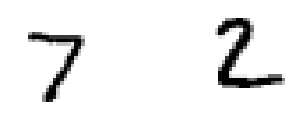

In [60]:
for i, image in enumerate([x_test[0], x_test[1]]):
    plt.subplot(2, 2, i + 1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')

Prepare scoring payload with records to score.

In [61]:
score_0 = (x_test[0].ravel() / 255).tolist()
score_1 = (x_test[1].ravel() / 255).tolist()

In [62]:
scoring_payload = {"input_data": [{"values": [score_0, score_1]}]}

Use ``client.deployments.score()`` method to run scoring.

In [63]:
predictions = client.deployments.score(deployment_uid, scoring_payload)

In [64]:
print(json.dumps(predictions, indent=2))

{
  "predictions": [
    {
      "fields": [
        "prediction",
        "prediction_classes",
        "probability"
      ],
      "values": [
        [
          [
            0.0,
            0.0,
            0.0,
            0.0,
            0.0,
            0.0,
            0.0,
            1.0,
            0.0,
            0.0
          ],
          7,
          [
            0.0,
            0.0,
            0.0,
            0.0,
            0.0,
            0.0,
            0.0,
            1.0,
            0.0,
            0.0
          ]
        ],
        [
          [
            0.0,
            0.0,
            1.0,
            0.0,
            0.0,
            0.0,
            0.0,
            0.0,
            0.0,
            0.0
          ],
          2,
          [
            0.0,
            0.0,
            1.0,
            0.0,
            0.0,
            0.0,
            0.0,
            0.0,
            0.0,
            0.0
          ]
        ]
      ]
    }

<a id="cleanup"></a>
## 7. Clean up 

In [65]:
client.export_assets.delete(export_job_id, space_id=export_space_id)
client.import_assets.delete(import_job_id, space_id=import_space_id)

client.spaces.delete(export_space_id)
client.spaces.delete(import_space_id)

Export job deleted
Import job deleted
DELETED
DELETED


'SUCCESS'

If you want to clean up all created assets:
- experiments
- trainings
- pipelines
- model definitions
- models
- functions
- deployments

please follow up this sample [notebook](https://github.com/IBM/watson-machine-learning-samples/blob/master/cloud/notebooks/python_sdk/instance-management/Machine%20Learning%20artifacts%20management.ipynb).

<a id="summary"></a>
## 8. Summary and next steps

 You successfully completed this notebook! You learned how to use export/import assets client apis. Check out our _[Online Documentation](https://console.ng.bluemix.net/docs/services/PredictiveModeling/index.html?pos=2)_ for more samples, tutorials, documentation, how-tos, and blog posts. 

### Authors

*Mithun - *vbmithun@in.ibm.com**, Software Engineer

Copyright © 2020 IBM. This notebook and its source code are released under the terms of the MIT License.